In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [15]:
from torchvision.models import googlenet


In [5]:
batch_size = 128      # imágenes por batch
num_workers = 2       # procesos paralelos para cargar datos
data_dir = "/content/drive/MyDrive/ColabNotebooks/CIFAR-10/"   # carpeta donde CIFAR10 será guardado


In [6]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [7]:
trainset = datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform_train
)

testset = datasets.CIFAR10(
    root=data_dir, train=False, download=True, transform=transform_test
)


100%|██████████| 170M/170M [00:05<00:00, 33.9MB/s]


In [8]:
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)


In [9]:
class_names = trainset.classes
print("Clases:", class_names)
print("Tamaño train:", len(trainset), "tamaño test:", len(testset))


Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Tamaño train: 50000 tamaño test: 10000


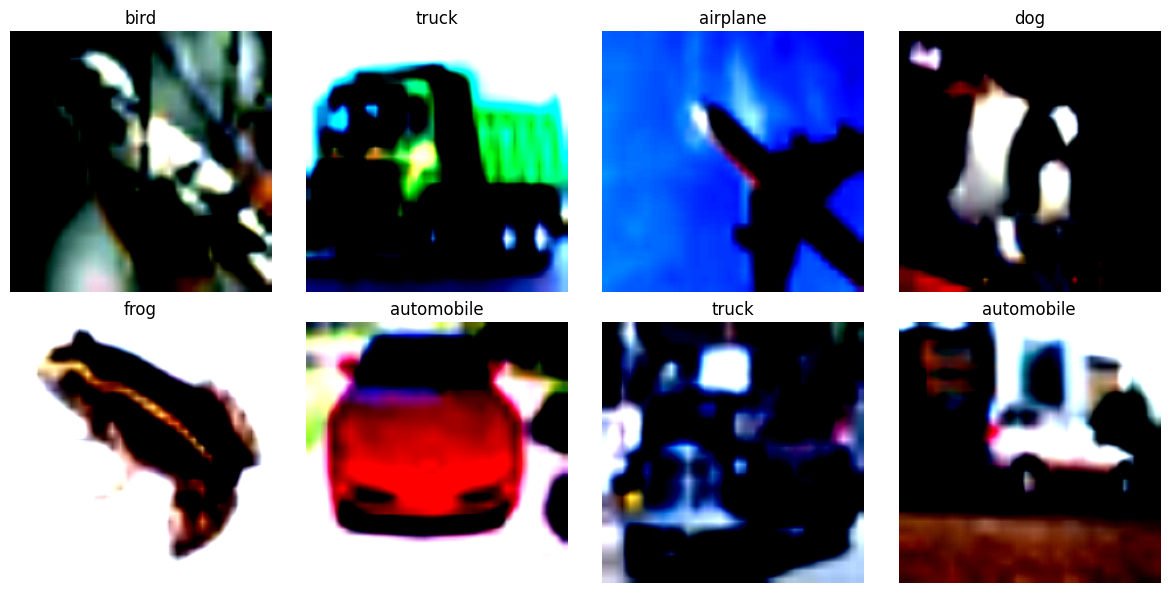

In [10]:
#imagenes normalizadas
# Obtener un batch
images, labels = next(iter(trainloader))

# Mostrar
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for img, label, ax in zip(images, labels, axes):
    img_np = img.permute(1, 2, 0).numpy()  # convertir a HWC
    ax.imshow(img_np)
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
# --- Función para desnormalizar ---
def denormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3,1,1)
    std  = torch.tensor(std).view(3,1,1)
    return img_tensor * std + mean


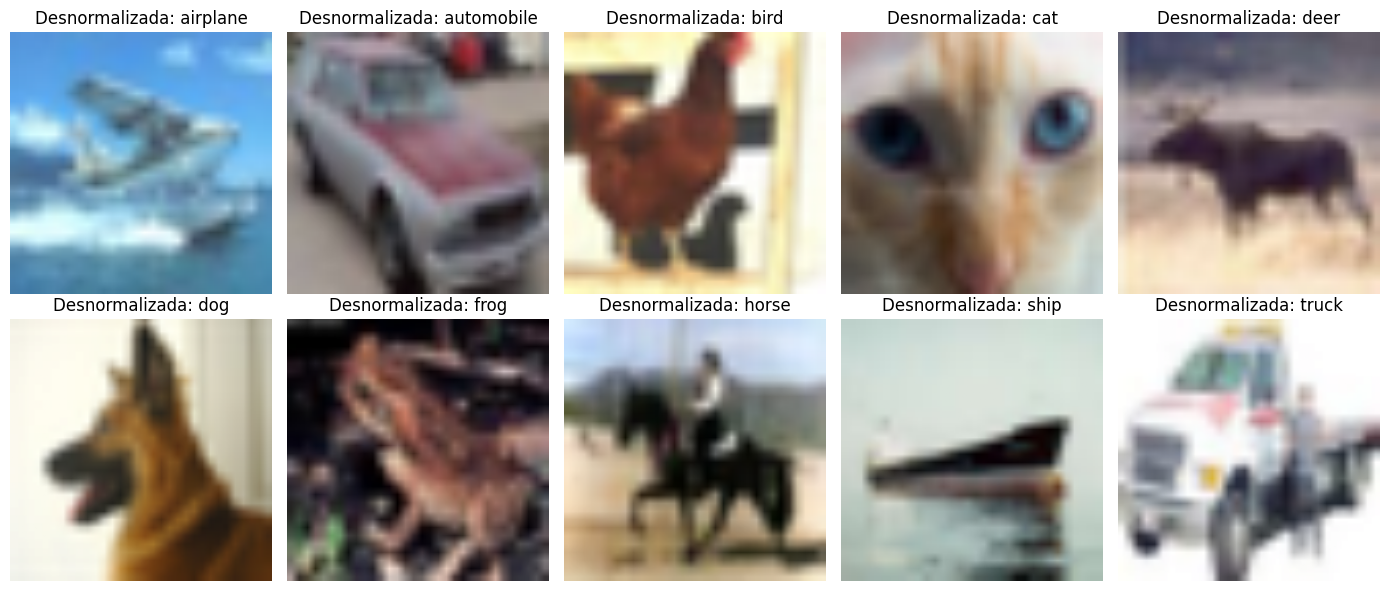

In [12]:
# --- Mostrar imágenes desnormalizadas ---
def show_denormalized_samples(dataset, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    axes = axes.flatten()

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    for i, cls in enumerate(class_names):
        idx = np.random.choice(np.where(np.array(dataset.targets) == i)[0])
        img, _ = dataset[idx]  # normalizada

        img_denorm = denormalize(img, mean, std)
        img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)

        axes[i].imshow(img_np)
        axes[i].set_title(f"Desnormalizada: {cls}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_denormalized_samples(trainset, class_names)


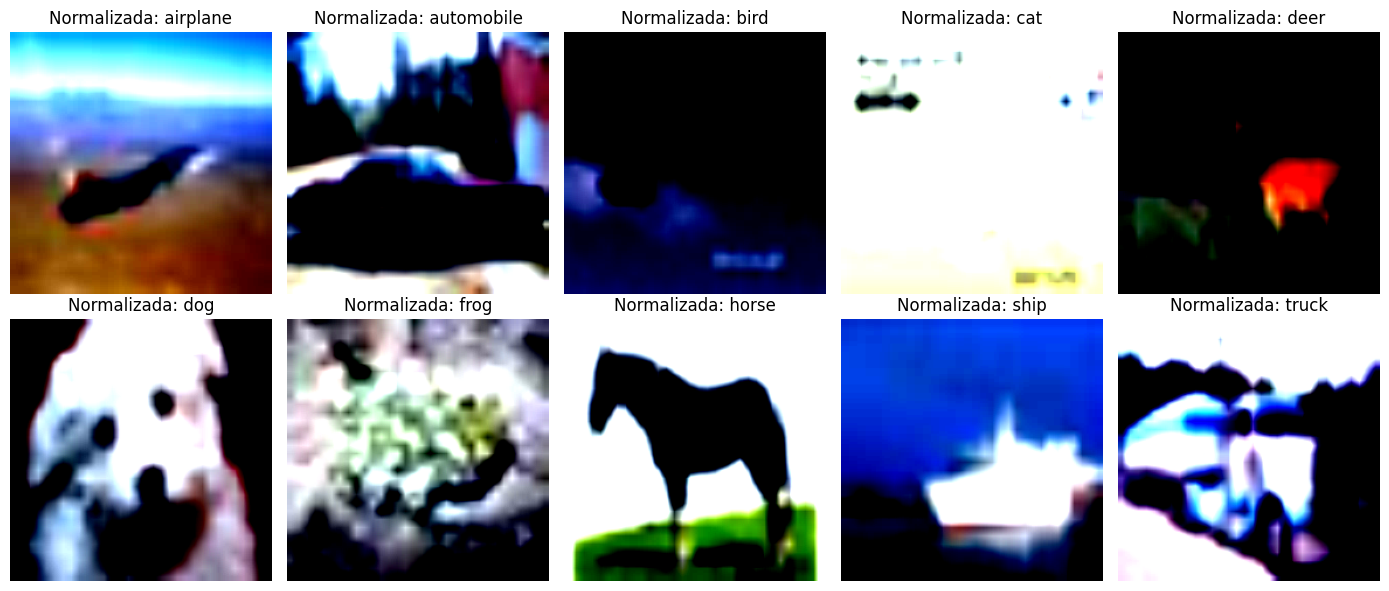

In [14]:
# --- Mostrar imágenes normalizadas ---
import matplotlib.pyplot as plt
import numpy as np

def show_normalized_samples(dataset, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    axes = axes.flatten()

    for i, cls in enumerate(class_names):
        idx = np.random.choice(np.where(np.array(dataset.targets) == i)[0])
        img, _ = dataset[idx]  # img está normalizada (tensor)

        img_np = img.permute(1, 2, 0).cpu().numpy()

        axes[i].imshow(img_np)
        axes[i].set_title(f"Normalizada: {cls}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_normalized_samples(trainset, class_names)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

NUM_EPOCHS = 10   # <<<< Ajusta aquí las épocas que quieras


In [ ]:
model = googlenet(pretrained=False, aux_logits=True)  # GoogLeNet puro, sin pesos
model.fc = torch.nn.Linear(1024, 10)                  # 10 clases de CIFAR-10

model.to(device)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, aux1, aux2 = model(images)

        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux1, labels)
        loss3 = criterion(aux2, labels)
        loss = loss1 + 0.3 * (loss2 + loss3)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device)
    test_loss,  test_acc  = evaluate(model, testloader, criterion, device)

    print(f"Época {epoch+1}/{NUM_EPOCHS}")
    print(f"  Entrenamiento -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Validación    -> Loss: {test_loss:.4f},  Acc: {test_acc:.4f}")


In [ ]:
save_path = "/content/drive/MyDrive/ColabNotebooks/CIFAR-10/googlenet_cifar10.pth"
torch.save(model.state_dict(), save_path)
print("Modelo guardado en:", save_path)
